# H-1B Visa Applications

Immigration is a hot and controversial topic in today's political culture. Because of this, we decided to conduct some analysis on the numbers and find out some truths. 

Mainly, the focus of this analysis is to answer the following question:

1. Geographical Analysis:
    * What are the states with the most applicants? 
  
2. Chronological Analysis: 
    * What is the year-by-year breakdown of applications? 
    
3. Wage Analysis: 
    * What is the wage distribution between the different states?

### Setup 

Here, we include all the 3rd party dependencies that we need for our project.

In [4]:
# Put all the imports here
import folium
import numpy as np
import pandas as pd
import plotly as ply
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

from geopy.geocoders import Nominatim
from matplotlib import pyplot as plt

# Make plotly work in offline mode
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

Read the relevant datasets. The dataset that are common to all the questions here is the H-1B dataset located in `./data/h1b.csv`. You can download this dataset from this [link](https://www.kaggle.com/nsharan/h-1b-visa/data).

In [5]:
# Load data
h1b_frame = pd.read_csv('./data/h1b.csv') # dataset to large, please download from README.md

### Geographical Analysis

 What are the states with the most applicants?**
 
In this section, we'll need another datasets that holds the geo-code and FIPS for each state. This data set is located in `./data/state_geocodes.csv`. 

In [12]:
geo_frame = pd.read_csv('./data/state_geocodes.csv')

Here, we collect some information and drop the irrelevant parts. We also add a column with the name of `count` and initialize all the values to 0. This column will store each application count. We also switch the indexing of the Dataframe to use the states name such as 'New York' or 'California' for easier access. 

The `top_cities` variable holds the top 100 cities. We then iterate through this list and extract the state name. We then increment the count in the `state_frame`. After doing so, we drop the states that have 0 applications. 

Please note that this particular code only looks at the top 100 cities and then splits it up by states. 

In [13]:
#### Heat Map of Applications by State ######
states_frame = geo_frame.drop('fips', axis=1)
states_frame['count'] = 0
states_frame = states_frame.set_index('name')

t = h1b_frame.loc[h1b_frame['CASE_STATUS'] == 'CERTIFIED']['WORKSITE'].value_counts()
    
for worksite, count in t.items():
    locations = worksite.split(',')
    state = locations[len(locations)-1].strip().lower().title()
    if state in states_frame.index:
        states_frame.at[state, 'count'] += count
states_frame = states_frame[states_frame['count'] != 0]

Now that `states_frame` contains the desired dataframe, we are ready to plot. 

In [14]:
# plot
map_data = './data/map/us_states.json'
m = folium.Map(location=[37, -102], zoom_start=3)

m.choropleth(
 geo_data=map_data,
 name='2011-2016 H-1B Visa Applications',
 data=states_frame,
 columns=['code', 'count'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='# of Applications'
)
m

---
**What are the states with the most certified applicants?**

Now, let's take a deeper look and analyze the whole dataset. First, let's grab all the date that have `CERTIFIED` case status. This means that the company and the individual who applied for the H-1B have met all the requirements. 

Alongside that, let's create a new dataframe containing state information.

In [15]:
# Certified H1Bs by State
t = h1b_frame.loc[h1b_frame['CASE_STATUS'] == 'CERTIFIED']['WORKSITE'].value_counts()

states = geo_frame['name'].tolist()
states_frame = geo_frame.drop('fips', axis=1)
states_frame['count'] = 0
states_frame = states_frame.set_index('name')

for worksite, count in t.items():
    state = worksite.split(',')[1].strip().lower().title()
    if state in states_frame.index.values:
        states_frame.at[state, 'count'] += count

        
states_frame = states_frame.sort_values('count')

X = states_frame[['code']].values.flatten()
Y = states_frame[['count']].values.flatten()

After attaining the proper X and Y, we are ready to plot. 

In [16]:
trace_states = go.Bar(
    x=X, 
    y=Y, 
    name="State", 
    text=Y, 
    textposition = 'auto')

data = [trace_states]
layout = go.Layout(
    title="H1Bs by State",
    barmode='stack'  
)
fig = go.Figure(
    data=data, 
    layout=layout
)
iplot(fig, 
      filename='stacked-bar', 
)

Let's narrow down and look at the top 10 states. This can be done by simply adjusting the indexing of X and Y.

In [17]:
# Top 10 states 
X = states_frame[['code']].values.flatten()[-10:]
Y = states_frame[['count']].values.flatten()[-10:]
trace_states = go.Bar(x=X, 
                    y=Y, 
                    name="State", 
                    text=Y, 
                    textposition = 'auto')

data = [trace_states]
layout = go.Layout(
    title="H1Bs by State",
    barmode='stack'  
)
fig = go.Figure(
    data=data, 
    layout=layout
)
iplot(fig, 
      filename='stacked-bar', 
)

---
**What is the location breakdown of number of applications for the top 3 state?**

In order to do this, let write a method that takes in a dataframe and state and plots the choropleth of the data. 

In [18]:
geolocator = Nominatim(scheme='http')
def get_county(coordinate):
    location = geolocator.reverse(f'{coordinate[0]}, {coordinate[1]}')
    return location.raw['address']['county']

In [21]:
def number_by_state(frame, state):
    # Transforming Data
    data = frame[frame['CASE_STATUS'] == 'CERTIFIED'][frame['WORKSITE'].str.contains(state.upper())]
    data = data[np.isfinite(data['lat']) & np.isfinite(data['lon'])]
    fips_frame = pd.read_csv('./data/county_geocodes.csv', dtype=str)
    fips_frame = fips_frame.set_index('Name')
    fips_frame['fips'] = fips_frame['State'] + fips_frame['County']
    state_code = fips_frame.at[state, 'State']
    fips_frame = fips_frame[fips_frame['State'] == state_code]

    # Setting up fresh Data Frame
    columns = ['name', 'count', 'lat', 'lon', 'county', 'fips']
    df = pd.DataFrame(columns=columns)
    df = df.set_index('name')
   
    for index, row in data.iterrows():
        city = row['WORKSITE']
        if city in df.index:
            df.at[city, 'count'] += 1
        else:
            lat = row['lat']
            lon = row['lon']
            county = get_county( (lat, lon) )
            if county in fips_frame.index:
                fips_code = fips_frame.at[county, 'fips']
            else:
                print(f'Unable to process {county}')
            df.loc[city] = [1, lat, lon, county, fips_code]

    df = df[df['count'] != 0]
    df = df.sort_values(by='count')
    # print(df)

    values = df['count'].tolist()
    fips = df['fips'].tolist()

    # Plotting
    colorscale = [
        'rgb(193, 193, 193)',
        'rgb(239,239,239)',
        'rgb(195, 196, 222)',
        'rgb(144,148,194)',
        'rgb(101,104,168)',
        'rgb(65, 53, 132)'
    ]

    scope = None
    if state is 'California':
        scope = 'CA'
    elif state is 'New York':
        scope = 'NY'
    elif state is 'Texas':
        scope = 'TX'

    fig = ff.create_choropleth(
        fips=fips, values=values, scope=[scope],
        binning_endpoints=[10, 100, 500, 1000, 10000], colorscale=colorscale,
        county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
        legend_title='# of Applications', title='Applications by County'
    )
    
    iplot(fig, filename=state)

Using our previous findings, the top 3 states are California, Texas, and New York. You can ignore any `UserWarning`. 
Note that I wasn't able to get `geolocator` to work in the notebook. Hence, these are commented out. 

* California

In [26]:
# number_by_state(h1b_frame, 'California')

* Texas

In [27]:
# number_by_state(h1b_frame, 'Texas')

* New York

In [28]:
# number_by_state(h1b_frame, 'New York')

---
**Who is the top Employer per State?**

This question is very interesting. We figured that different states would have different top employers due to the dominant industry of that give state. 

In [22]:
states_frame = geo_frame.drop('fips', axis=1)
states_frame['top_employer'] = ''
states_frame['count'] = 0
states_frame = states_frame.set_index('name')

for state in states_frame.index:
    data = h1b_frame[h1b_frame['CASE_STATUS'] == 'CERTIFIED'][h1b_frame['WORKSITE'].str.contains(state.upper())]
    counts = data['EMPLOYER_NAME'].value_counts()
    top_employer = counts.keys().tolist()[0]
    top_count = counts.tolist()[0]
    states_frame.at[state, 'top_employer'] = top_employer
    states_frame.at[state, 'count'] = top_count

states_frame = states_frame.sort_values('count')
# print(states_frame)
# states_frame.to_csv('../data/top_employer_by_state.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Now, that `states_frame` is ready again, we can get to plotting.

In [23]:
X = states_frame[['code']].values.flatten()
Y = states_frame[['count']].values.flatten()
text = states_frame[['top_employer']].values.flatten()

trace_states = go.Bar(
    x=X, 
    y=Y, 
    name="State", 
    text=text, 
    textposition = 'auto')

data = [trace_states]
layout = go.Layout(title="H1Bs by State", barmode='stack')
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

Let's focus on the top 10 states...

In [24]:
states_frame = states_frame[-10:]
X = states_frame[['code']].values.flatten()
Y = states_frame[['count']].values.flatten()
text = states_frame[['top_employer']].values.flatten()

trace_states = go.Bar(
    x=X, 
    y=Y, 
    name="State", 
    text=text, 
    textposition = 'auto')

data = [trace_states]
layout = go.Layout(title="H1Bs by State", barmode='stack')
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

We see that INFOSYS LIMITED is an overwhelming favorite for applying for an H-1B visa.

---
**What is the Average Salary of the Top Employer of each state?**

Now that we are aware of the top company that applies for H-1B visas. Let's figure out what is the average salary they offer their employees.

In [20]:
data = h1b_frame[h1b_frame['CASE_STATUS'] == 'CERTIFIED']
df = pd.read_csv('./data/top_employer_by_state.csv')
df = df.set_index('name')

for state, row in df.iterrows():
    employer = row['top_employer']
    wages = data[data['WORKSITE'].str.contains(state.upper())][data['EMPLOYER_NAME'] == employer]['PREVAILING_WAGE']
    df.at[state, 'average_salary'] = round(wages.mean(), 2)
    
df.sort_index()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,code,top_employer,count,average_salary
name,,,,
Alabama,AL,THE UNIV. OF ALA. AT BIRMINGHAM (UAB),946,47095.38
Alaska,AK,UNIVERSITY OF ALASKA,114,55792.98
Arizona,AZ,INFOSYS LIMITED,5641,64562.35
Arkansas,AR,INFOSYS LIMITED,2057,53797.90
California,CA,INFOSYS LIMITED,23597,83573.26
Colorado,CO,INFOSYS LIMITED,1871,71671.67
Connecticut,CT,INFOSYS LIMITED,4556,71549.91
Delaware,DE,TATA CONSULTANCY SERVICES LIMITED,1172,65719.35
District Of Columbia,DC,INFOSYS LIMITED,437,81681.22


Now that `df` is ready, we can begin plotting

In [25]:
map_data = '/Users/hirad.pourtahmasbi/Dev/h1b-analysis/data/map/us_states.json'
m = folium.Map(location=[37, -102], zoom_start=4)
m.choropleth(
    geo_data=map_data,
    name='2011-2016 Average Salary of Top Employer per State',
    data=df,
    columns=['code', 'average_salary'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Salary'
)
folium.LayerControl().add_to(m)
m

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hirad.pourtahmasbi/Dev/h1b-analysis/data/map/us_states.json'

---
### Chronological Analysis: 

* What is the year-by-year breakdown of applications? 

In [18]:
# Histogram for number of applications per year
years_frame_non_cert = h1b_frame.loc[h1b_frame['CASE_STATUS'] != 'CERTIFIED'].groupby('YEAR').count()
X = years_frame_non_cert.index.values
Y = years_frame_non_cert[['Unnamed: 0']].values.flatten()
trace_non_cert = go.Bar(x=X, 
                        y=Y, 
                        name="Non-Certified",
                        text=Y, 
                        textposition = 'auto')

# Histogram for number of applications per year that are 'CERTIFIED', 
# which means 'meeting the minumum requirement'.
years_frame_cert = h1b_frame.loc[h1b_frame['CASE_STATUS'] == 'CERTIFIED'].groupby('YEAR').count()
X = years_frame_cert.index.values
Y = years_frame_cert[['Unnamed: 0']].values.flatten()
trace_cert = go.Bar(x=X, 
                    y=Y, 
                    name="Certified", 
                    text=Y, 
                    textposition = 'auto')

data = [trace_cert, trace_non_cert]
layout = go.Layout(
    title="Certified vs Non-Certified H1B applications per Year",
    barmode='stack'  
)
fig = go.Figure(
    data=data, 
    layout=layout
)
iplot(fig, 
      filename='stacked-bar', 
)

In [27]:
# Creating a dataframe with columns
h1b_frame_with_states = pd.read_csv("./data/h1b.csv")
h1b_frame_with_states['state'] = ''
h1b_frame_with_states['state'] = h1b_frame_with_states['WORKSITE']
tr = []
for worksite in h1b_frame_with_states['state']:
    tr.append(worksite.split(',')[1].strip().title())
h1b_frame_with_states['state'] = tr

In [39]:
# saving h1b data frame with states into the file
# df.to_csv("./data/h1b_with_states.csv")
# h1b_frame_with_states = pd.read_csv("./data/h1b_with_states.csv")

In [28]:
# Does the number of applications is the same when looked in proporion with with state population (per year)? 
h1b_frame_group = h1b_frame_with_states.loc[ h1b_frame_with_states['CASE_STATUS'] == 'CERTIFIED']
h1b_frame_group = h1b_frame_group.loc[ h1b_frame_group['state'] != 'Na']
h1b_frame_group = h1b_frame_group.loc[ h1b_frame_group['YEAR'] == 2016 ]
h1b_frame_group = h1b_frame_group.groupby('state').count()
population_estimates_frame = pd.read_csv("./data/population_est.csv")

h1b_frame_group['population 2016'] = 0 
l = list(population_estimates_frame['2016'])
h1b_frame_group['population 2016'] = l
h1b_frame_group['ratio to population'] =  (h1b_frame_group['Unnamed: 0'] / h1b_frame_group['population 2016']) * 100

X = h1b_frame_group.index.values
Y = h1b_frame_group['ratio to population'].values.flatten()
trace1 = go.Bar(
    x=X,
    y=Y,
    name='Ratios'
)

data = [trace1]
layout = go.Layout(
    barmode='stack'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped')


#counts 
X = h1b_frame_group.index.values
Y = h1b_frame_group['Unnamed: 0'].values.flatten()

trace1 = go.Bar(
    x=X,
    y=Y,
    name='Ratios'
)

data = [trace1]
layout = go.Layout(
    barmode='stack'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped')



--- 
### Wage Analysis

Let's first take a look at the typical wage of the applicants. The wage that are sometimes reported are abnormally high. Therefore, we should exclude applicants that have a higher than normal wage. It is up to you to decide the cuttoff, we decided on $400,000. 

In [24]:
df = h1b_frame[(h1b_frame['PREVAILING_WAGE'] < 400000) & (h1b_frame['CASE_STATUS'] == 'CERTIFIED')]
df = df.dropna(axis=0, how='all')

After this, the dataframe is pratically ready and we are ready for ploting histograms. The configuration fields here are optional to the use.

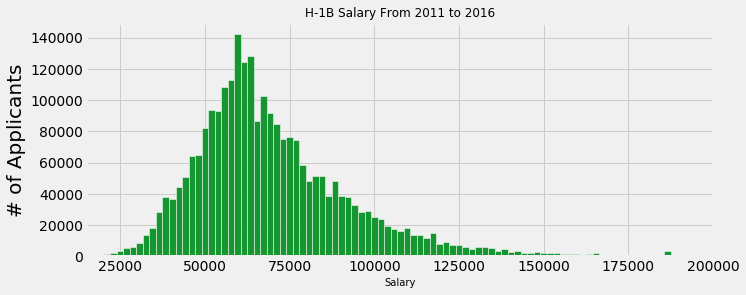

In [25]:
title = 'H-1B Salary From 2011 to 2016'

with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.hist(df['PREVAILING_WAGE'], bins=200, edgecolor='#ffffff', color='#169630')

ax.set_title(title)
plt.xlim([15000, 200000])
plt.xlabel('Salary',size=10)
plt.ylabel('# of Applicants', size=20)

# plt.savefig('../graphs/' + title + '.png') # Saving the generated graph
plt.show()

Now we will look at the average wage salary based on occupation.

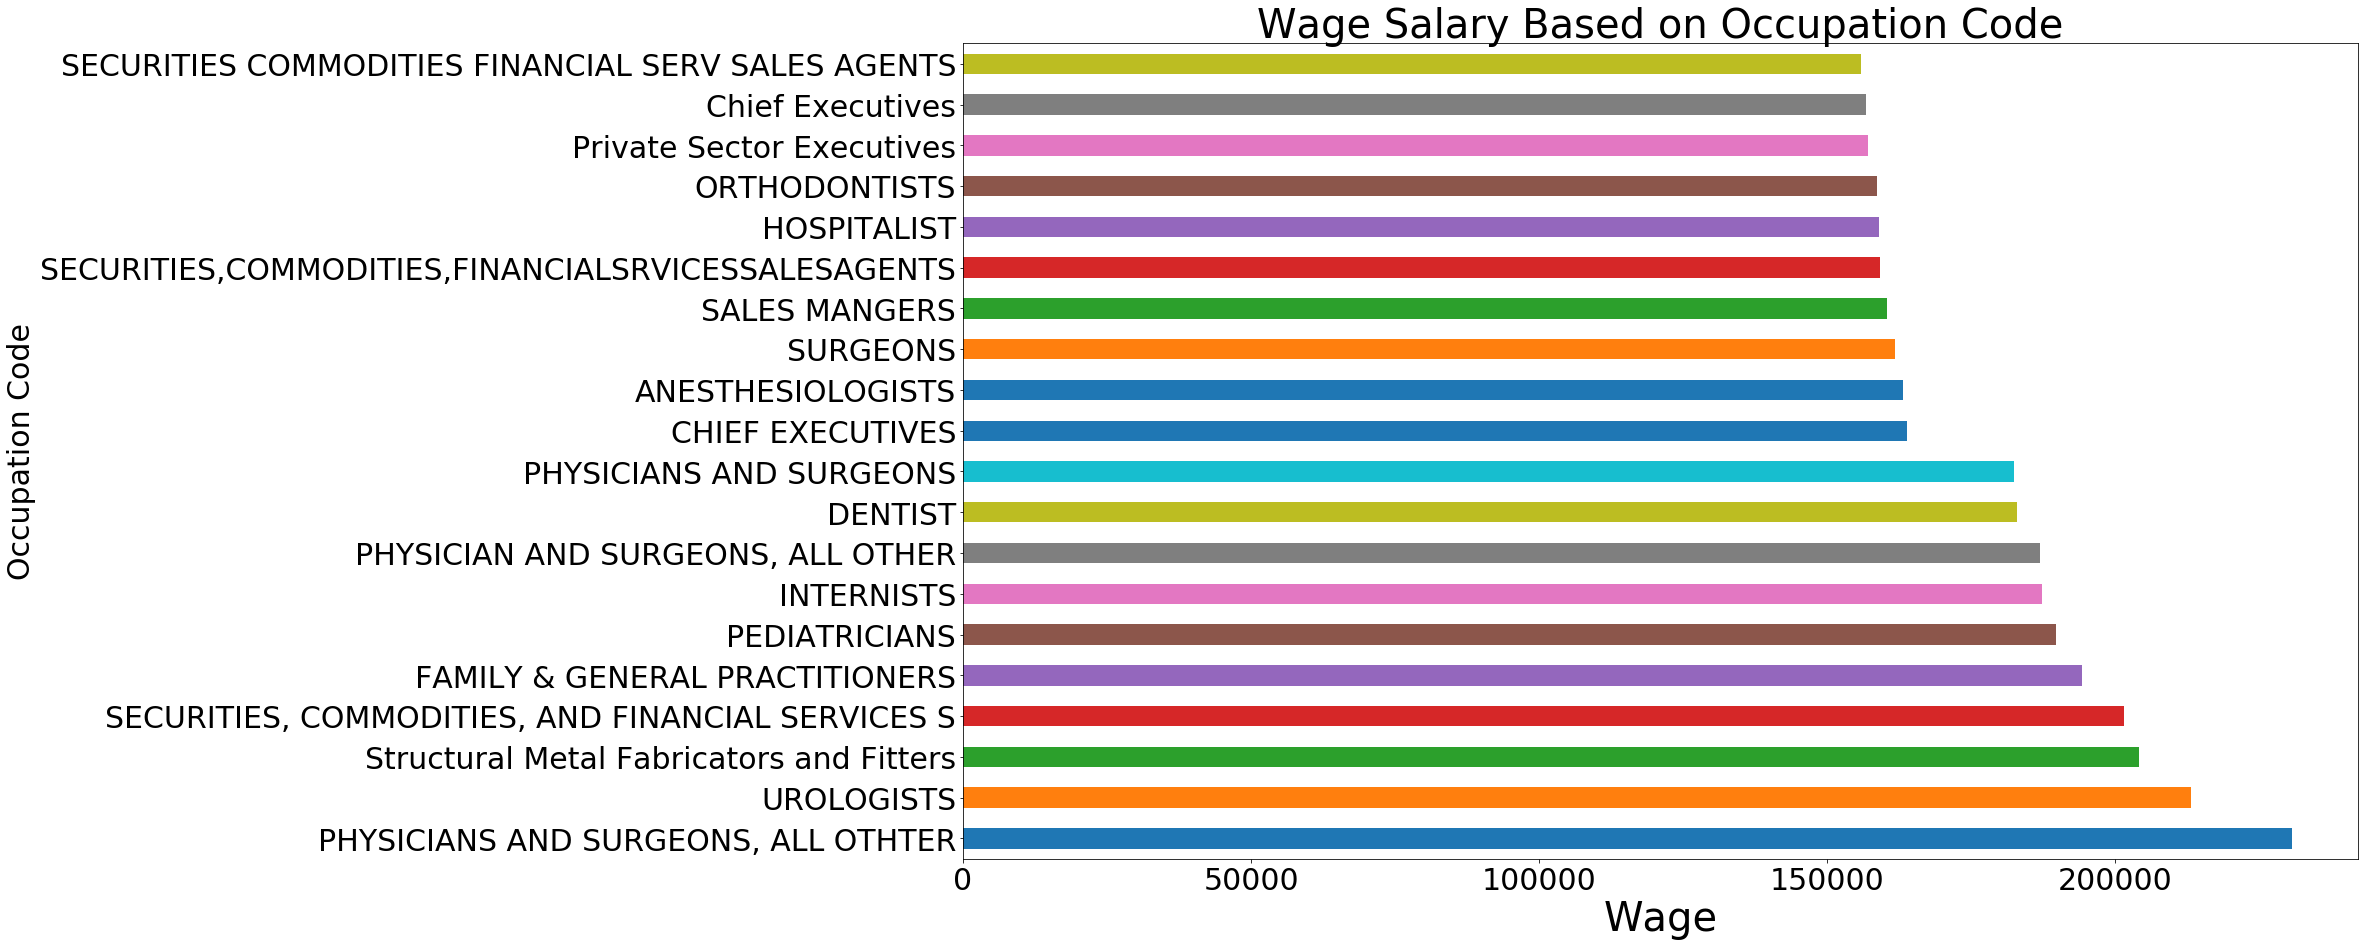

In [34]:
dFrame = h1b_frame[(h1b_frame['PREVAILING_WAGE'] < 400000) & (h1b_frame['CASE_STATUS'] == 'CERTIFIED')]
dFrame = dFrame.groupby('SOC_NAME')['PREVAILING_WAGE'].mean().nlargest(20)

ax = plt.subplot(111)
dFrame.plot(kind='barh', figsize=(25, 15), ax=ax);
ax.set_xlabel('Wage', size = 40)
ax.set_ylabel('Occupation Code', size = 30)
ax.set_title('Wage Salary Based on Occupation Code', size = 40)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

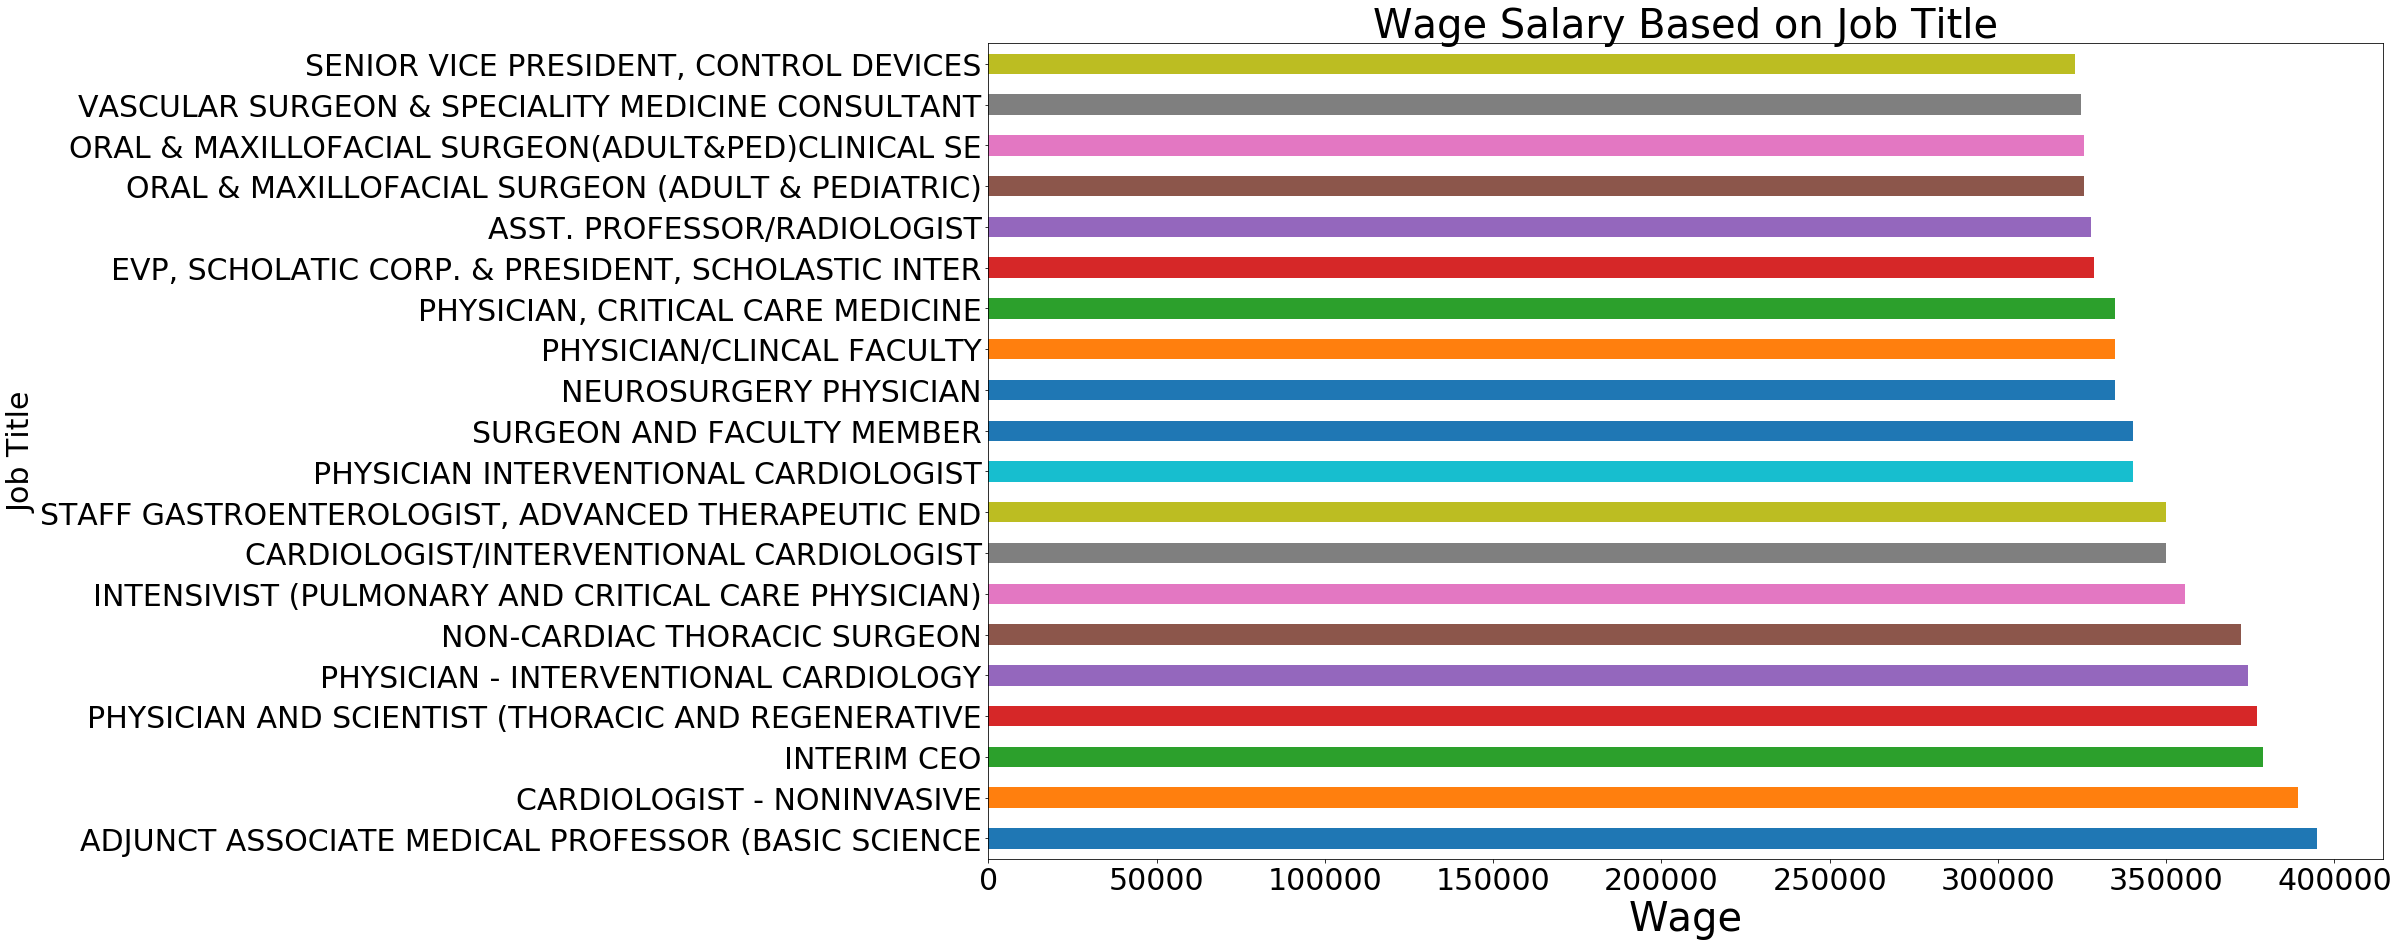

In [37]:
dFrame = h1b_frame[(h1b_frame['PREVAILING_WAGE'] < 400000) & (h1b_frame['CASE_STATUS'] == 'CERTIFIED')]
dFrame = dFrame.groupby('JOB_TITLE')['PREVAILING_WAGE'].mean().nlargest(20)

ax = plt.subplot(111)
dFrame.plot(kind='barh', figsize=(25, 15), ax=ax);
ax.set_xlabel('Wage', size = 40)
ax.set_ylabel('Job Title', size = 30)
ax.set_title('Wage Salary Based on Job Title', size = 40)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)